In [88]:
# import objects from numpy, matplotlib, and QuTiP
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmax, sigmay, sigmaz, basis, rand_ket, \
     floquet_modes, floquet_modes_t, floquet_state_decomposition, \
     floquet_wavefunction_t, expect, mesolve, num, \
     floquet_modes_table, floquet_modes_t_lookup, \
     floquet_wavefunction

# define constants
π = np.pi
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()

# $H(t) = -\frac{1}{2}\delta \sigma_x  - \frac{1}{2} \epsilon_0 \sigma_z + \frac{1}{2}A \sin(\omega t) \sigma_z$

In [9]:
δ = 0.2 * 2*π
ϵ0 = 1.0 * 2*π
A = 2.5 * 2*π
ω = 1.0 * 2*π
H0 = - δ/2.0 * σ_x - ϵ0/2.0 * σ_z
H1 = A/2.0 * sigmaz()
args = {'w': ω}
H = [H0, [H1, 'sin(w * t)']]

In [10]:
T = 2*π/ω
f_modes_0, f_energies = floquet_modes(H, T, args)
f_energies

array([-2.83131212,  2.83131212])

In [11]:
f_modes_0 

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[ 0.72964231+0.j      ]
  [-0.39993746+0.554682j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.39993746+0.554682j]
  [0.72964231+0.j      ]]]

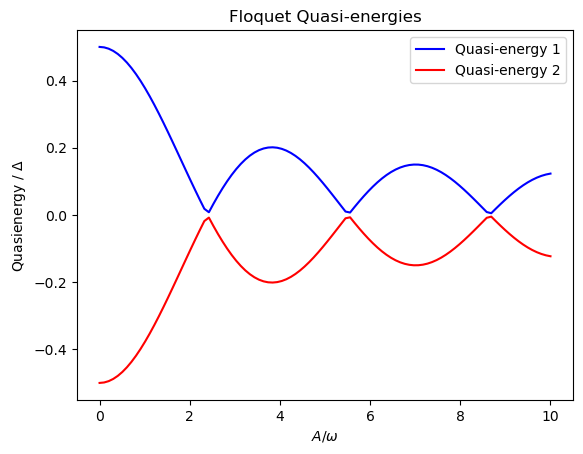

In [33]:
# define detuning, static field, and drive frequency
δ = 0.2 * 2*π
ϵ0  = 0.0 * 2*π
ω = 1.0 * 2*π

# define array of timesteps 
A_vec = np.linspace(0, 10, 100) * ω
T = (2*π)/ω
tlist = np.linspace(0.0, 10 * T, 101)

# define array in which to store quasienergies
q_energies = np.zeros((len(A_vec), 2))

# define static Hamiltonian
H0 = δ/2.0 * σ_z - ϵ0/2.0 * σ_x
args = {'w': ω}

for idx, A in enumerate(A_vec):
    
    # defines the dynamic part of the Hamiltonian wtihout 
    # explicit time dependence, i.e, drive term
    H1 = (A/2.0)*σ_x
    
    # compute Floquet modes and Floquet energies
    H = [H0, [H1, lambda t, args: np.sin(args['w']*t)]] 
    f_modes, f_energies = floquet_modes(H, T, args, True)
    q_energies[idx,:] = f_energies 

plt.figure() 


# prepare data and plot features
x_data = A_vec / ω
y_datasets = [q_energies[:, i] / δ for i in range(2)]
colors = ['b', 'r']  # List of colors for the plots
labels = ['Quasi-energy 1', 'Quasi-energy 2']  # Labels for each dataset

# Create the plot
for y_data, color, label in zip(y_datasets, colors, labels):
    plt.plot(x_data, y_data, color, label=label)

plt.xlabel(r'$A/\omega$') 
plt.ylabel(r'Quasienergy / $\Delta$') 
plt.title(r'Floquet Quasi-energies') 
plt.legend()
plt.show()

In [34]:
# find the Floquet modes at some later time 't'
f_modes_t = floquet_modes_t(f_modes_0, f_energies, 2.5, H, T, args)
f_modes_t 

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.89630512-0.23191946j]
  [ 0.37793106-0.00431336j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.37793106-0.00431336j]
  [-0.89630512+0.23191946j]]]

In [35]:
# decompose the initial state |ψ0> in the Floquet states
ψ0 = rand_ket(2)
f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)
f_coeff 

[(0.5563835151862844-0.4788293107882772j),
 (-0.3994927530154464+0.5491497204288801j)]

In [40]:
# evaluate the wavefunction that is the solution to our Hamiltonian
# at an arbitrary time t
t = 10 * np.random.rand()
ψt = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, T, args)
ψt

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.06487818-0.48907611j]
 [-0.71903966+0.48946639j]]

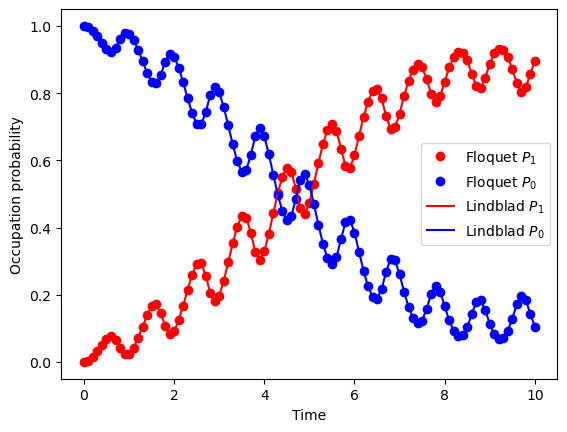

In [86]:
δ = 0.2 * 2*π
ϵ0 = 1.0 * 2*π
A = 0.5 * 2*π
omega = 1.0 * 2*π
T = (2*π)/ω
tlist = np.linspace(0.0, 10 * T, 101)
ψ0 = basis(2, 0)

H0 = - δ/2.0 * σ_x - ϵ0/2.0 * σ_z
H1 = A/2.0 * σ_z
args = {'w': omega}
H = [H0, [H1, lambda t,args: np.sin(args['w'] * t)]]

# find the floquet modes for the time-dependent Hamiltonian
f_modes_0, f_energies = floquet_modes(H, T, args)

# decompose the inital state in the floquet modes
f_coeff = floquet_state_decomposition(f_modes_0, f_energies, ψ0)

# calculate the wavefunctions using the from the floquet modes
p_ex = np.zeros(len(tlist))
for n, t in enumerate(tlist):
    ψt = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, T, args)
    p_ex[n] = expect(num(2), ψt)

# For reference: calculate the same thing with mesolve
p_ex_ref = mesolve(H, ψ0, tlist, [], [num(2)], args).expect[0]

# plot the results
plt.plot(tlist, np.real(p_ex),     'ro', tlist, 1-np.real(p_ex),     'bo')
plt.plot(tlist, np.real(p_ex_ref), 'r',  tlist, 1-np.real(p_ex_ref), 'b')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend(("Floquet $P_1$", "Floquet $P_0$", "Lindblad $P_1$", "Lindblad $P_0$"))
plt.show()

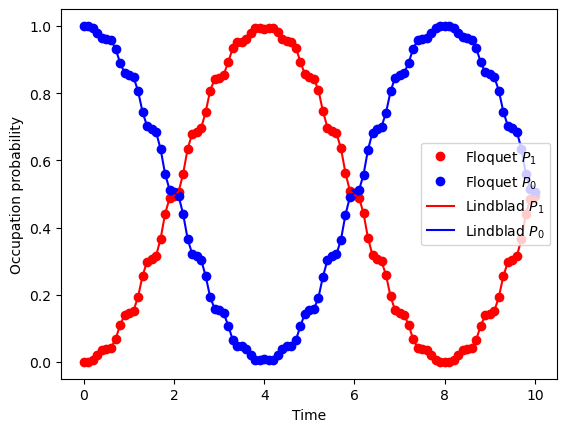

In [87]:
# precompute Floquet modes
δ = 0.0  * 2*π
ϵ0 = 1.0 * 2*π
A = 0.25 * 2*π
ω = 1.0 * 2*π
T = 2*π/ω
tlist = np.linspace(0.0, 10 * T, 101)
ψ0 = basis(2,0)

H0 = - δ/2.0 * σ_x - ϵ0/2.0 * σ_z
H1 = A/2.0 * σ_x
args = {'w': ω}
H = [H0, [H1, lambda t, args: np.sin(args['w'] * t)]]

# find the floquet modes for the time-dependent hamiltonian        
f_modes_0,f_energies = floquet_modes(H, T, args)

# decompose the inital state in the floquet modes
f_coeff = floquet_state_decomposition(f_modes_0, f_energies, ψ0)

# calculate the wavefunctions using the from the floquet modes
f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, args)
p_ex = np.zeros(len(tlist))
for n, t in enumerate(tlist):
    f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T)
    ψt = floquet_wavefunction(f_modes_t, f_energies, f_coeff, t)
    p_ex[n] = expect(num(2), ψt)

# For reference: calculate the same thing with mesolve
p_ex_ref = mesolve(H, ψ0, tlist, [], [num(2)], args).expect[0]

# plot the results
plt.plot(tlist, np.real(p_ex),     'ro', tlist, 1-np.real(p_ex),     'bo')
plt.plot(tlist, np.real(p_ex_ref), 'r',  tlist, 1-np.real(p_ex_ref), 'b')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend(("Floquet $P_1$", "Floquet $P_0$", "Lindblad $P_1$", "Lindblad $P_0$"))
plt.show()